In [114]:
import numpy as np
import pandas as pd
import pyspark
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, min, max, count

spark = SparkSession.builder.appName("CarDatasetAnalysis").getOrCreate()

df = spark.read.csv("car_price_dataset.csv", header=True, inferSchema=True)

df.show(5)

# Data retrieved from
#https://www.kaggle.com/datasets/asinow/car-price-dataset?resource=download

+----------+------+----+-----------+---------+--------------+-------+-----+-----------+-----+
|     Brand| Model|Year|Engine_Size|Fuel_Type|  Transmission|Mileage|Doors|Owner_Count|Price|
+----------+------+----+-----------+---------+--------------+-------+-----+-----------+-----+
|       Kia|   Rio|2020|        4.2|   Diesel|        Manual| 289944|    3|          5| 8501|
| Chevrolet|Malibu|2012|        2.0|   Hybrid|     Automatic|   5356|    2|          3|12092|
|  Mercedes|   GLA|2020|        4.2|   Diesel|     Automatic| 231440|    4|          2|11171|
|      Audi|    Q5|2023|        2.0| Electric|        Manual| 160971|    2|          1|11780|
|Volkswagen|  Golf|2003|        2.6|   Hybrid|Semi-Automatic| 286618|    3|          3| 2867|
+----------+------+----+-----------+---------+--------------+-------+-----+-----------+-----+
only showing top 5 rows



In [116]:
df.describe().show()  
#df.printSchema()   #print summary statistics  
#df.show(5) 

+-------+----------+--------+-----------------+------------------+---------+--------------+-----------------+-----------------+------------------+------------------+
|summary|     Brand|   Model|             Year|       Engine_Size|Fuel_Type|  Transmission|          Mileage|            Doors|       Owner_Count|             Price|
+-------+----------+--------+-----------------+------------------+---------+--------------+-----------------+-----------------+------------------+------------------+
|  count|     10000|   10000|            10000|             10000|    10000|         10000|            10000|            10000|             10000|             10000|
|   mean|      NULL|    NULL|        2011.5437|3.0005599999999966|     NULL|          NULL|      149239.1118|           3.4971|            2.9911|         8852.9644|
| stddev|      NULL|    NULL|6.897698756455926|1.1493240539456635|     NULL|          NULL|86322.34895733812|1.110096762215867|1.4226816904421142|3112.5968102892775|
|   

In [117]:
null_counts = []
for column in df.columns:
    count = df.filter(col(column).isNull()).count()
    null_counts.append((column, count))

null_df = spark.createDataFrame(null_counts, ["Column", "NULL_Count"])
null_df.show()

+------------+----------+
|      Column|NULL_Count|
+------------+----------+
|       Brand|         0|
|       Model|         0|
|        Year|         0|
| Engine_Size|         0|
|   Fuel_Type|         0|
|Transmission|         0|
|     Mileage|         0|
|       Doors|         0|
| Owner_Count|         0|
|       Price|         0|
+------------+----------+



In [118]:
duplicate_count = df.count() - df.dropDuplicates().count()
print(f"Duplicate Rows: {duplicate_count}")

Duplicate Rows: 0


In [119]:
df.select(
    col("price"),
    col("mileage"),
    col("year"),
    col("engine_size")
).describe().show()

+-------+------------------+-----------------+-----------------+------------------+
|summary|             price|          mileage|             year|       engine_size|
+-------+------------------+-----------------+-----------------+------------------+
|  count|             10000|            10000|            10000|             10000|
|   mean|         8852.9644|      149239.1118|        2011.5437|3.0005599999999966|
| stddev|3112.5968102892775|86322.34895733812|6.897698756455926|1.1493240539456635|
|    min|              2000|               25|             2000|               1.0|
|    max|             18301|           299947|             2023|               5.0|
+-------+------------------+-----------------+-----------------+------------------+



In [120]:
df.select("fuel_type").distinct().show()
df.select("transmission").distinct().show()
df.select("brand").distinct().show()

+---------+
|fuel_type|
+---------+
|   Diesel|
|   Hybrid|
| Electric|
|   Petrol|
+---------+

+--------------+
|  transmission|
+--------------+
|     Automatic|
|        Manual|
|Semi-Automatic|
+--------------+

+----------+
|     brand|
+----------+
|Volkswagen|
|       Kia|
| Chevrolet|
|   Hyundai|
|     Honda|
|      Audi|
|  Mercedes|
|       BMW|
|    Toyota|
|      Ford|
+----------+



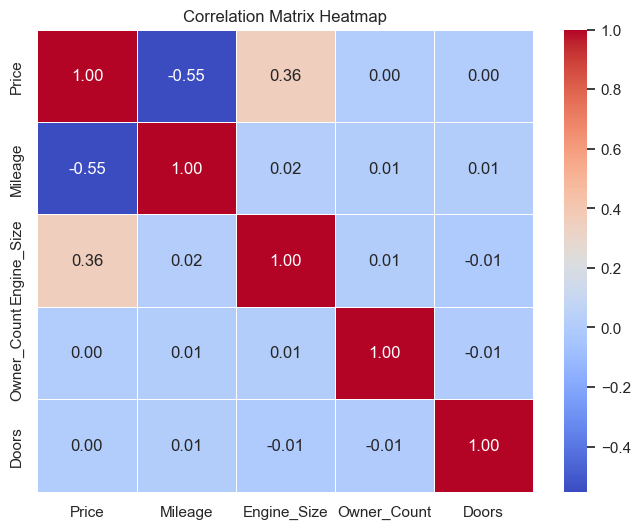

In [121]:

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Convert numerical columns into a single vector column
vector_col = "features"
assembler = VectorAssembler(inputCols=["Price", "Mileage", "Engine_Size", "Owner_Count", "Doors"], outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

correlation_matrix = Correlation.corr(df_vector, vector_col).head()[0]

corr_array = correlation_matrix.toArray()  # Convert to NumPy array
columns = ["Price", "Mileage", "Engine_Size", "Owner_Count", "Doors"]
df_corr = pd.DataFrame(corr_array, columns=columns, index=columns)

# Plot the correlation matrix inside the cell
plt.figure(figsize=(8, 6))
sns.heatmap(df_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()  #display plot


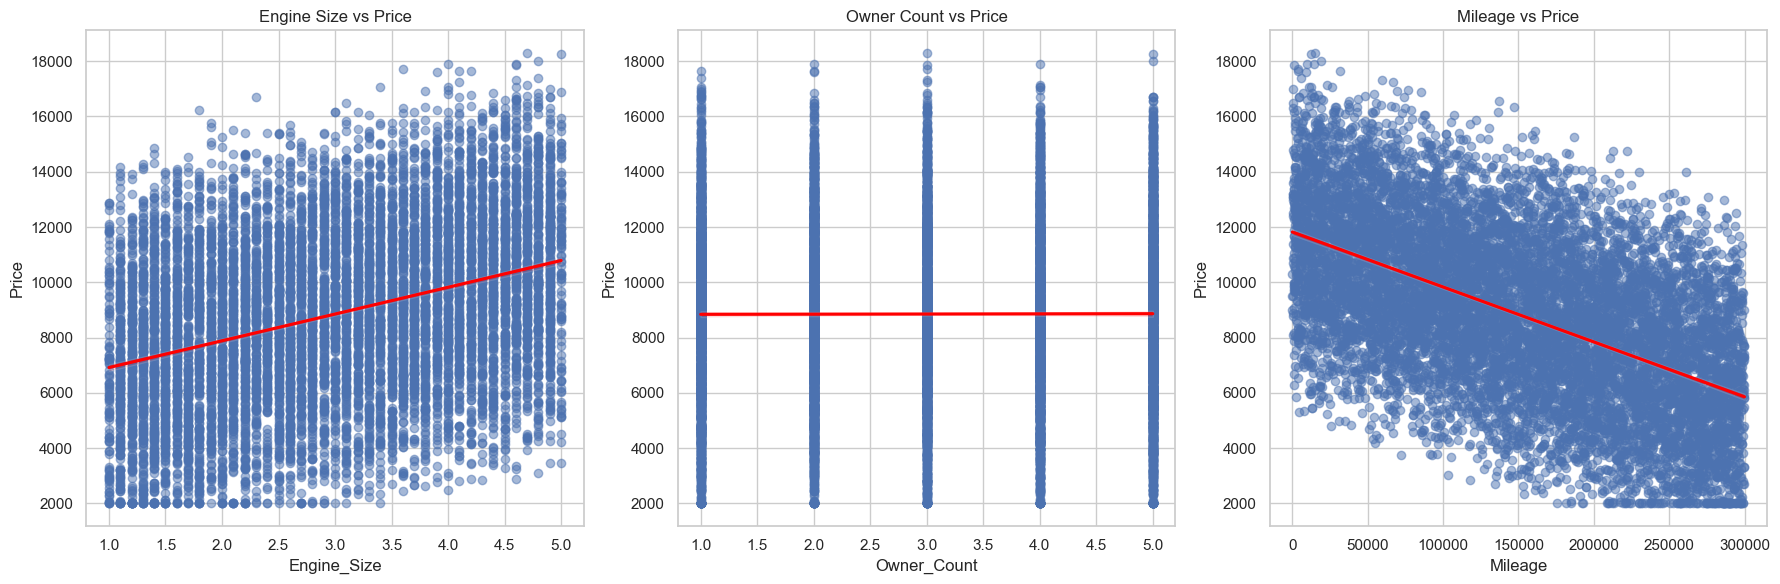

In [122]:
# Convert PySpark DataFrame to Pandas for plotting
df_pandas = df.select("Price", "Engine_Size", "Owner_Count", "Mileage").toPandas()

# Set plot style
sns.set(style="whitegrid")

# Create subplots for multiple regression plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Engine Size vs Price
sns.regplot(x="Engine_Size", y="Price", data=df_pandas, ax=axes[0], scatter_kws={'alpha':0.5}, line_kws={"color": "red"})
axes[0].set_title("Engine Size vs Price")

# Owner Count vs Price
sns.regplot(x="Owner_Count", y="Price", data=df_pandas, ax=axes[1], scatter_kws={'alpha':0.5}, line_kws={"color": "red"})
axes[1].set_title("Owner Count vs Price")

# Mileage vs Price
sns.regplot(x="Mileage", y="Price", data=df_pandas, ax=axes[2], scatter_kws={'alpha':0.5}, line_kws={"color": "red"})
axes[2].set_title("Mileage vs Price")

# Show the plots
plt.tight_layout()
plt.show()

#Looks like engine size and mileage have correlation with price, but owner_count has little influence on price (the heatmap shown last 
#seemed to indicate a relationship)

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql import SparkSession

# Start Spark Session
spark = SparkSession.builder.appName("CarPricePrediction").getOrCreate()

# Load Data
df = spark.read.csv("car_price_dataset.csv", header=True, inferSchema=True)

# Select Only Numerical Columns
numerical_cols = ["Engine_Size", "Mileage", "Doors", "Owner_Count"]

# Assemble Features
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
df_numeric_transformed = assembler.transform(df).select("features", "Price")


#df_numeric_transformed.show(5, truncate=False)


+----------------------+-----+
|features              |Price|
+----------------------+-----+
|[4.2,289944.0,3.0,5.0]|8501 |
|[2.0,5356.0,2.0,3.0]  |12092|
|[4.2,231440.0,4.0,2.0]|11171|
|[2.0,160971.0,2.0,1.0]|11780|
|[2.6,286618.0,3.0,3.0]|2867 |
+----------------------+-----+
only showing top 5 rows



In [124]:
train_data, test_data = df_numeric_transformed.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression(featuresCol="features", labelCol="Price", regParam=0.1)
lr_model = lr.fit(train_data)

test_results = lr_model.evaluate(test_data)

print("R² Score:", test_results.r2)
print("RMSE:", test_results.rootMeanSquaredError)



R² Score: 0.4365462046728764
RMSE: 2347.581561495417


In [125]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

def one_hot_encode_categorical(df, categorical_columns):
    transformed_df = df

    # Step 1: String Indexing (Creates columns like "BrandIndex", "ModelIndex", etc.)
    indexers = [StringIndexer(inputCol=col, outputCol=col + "Index", handleInvalid="keep").fit(transformed_df) 
                for col in categorical_columns]

    for indexer in indexers:
        transformed_df = indexer.transform(transformed_df)

    # Step 2: One-Hot Encoding (Creates columns like "BrandVec", "ModelVec", etc.)
    encoders = [OneHotEncoder(inputCol=col + "Index", outputCol=col + "Vec", dropLast=False).fit(transformed_df) 
                for col in categorical_columns]

    for encoder in encoders:
        transformed_df = encoder.transform(transformed_df)

    return transformed_df




def vectorize_numerical(df, numerical_columns):
    assembler = VectorAssembler(inputCols=numerical_columns, outputCol="numerical_features")
    df_transformed = assembler.transform(df)

    return df_transformed





def prepare_features(df, categorical_columns, numerical_columns, label_col="Price"):
    # Apply one-hot encoding dynamically
    df_transformed = one_hot_encode_categorical(df, categorical_columns)

    # Vectorize numerical columns
    assembler = VectorAssembler(inputCols=numerical_columns, outputCol="numerical_features")
    df_transformed = assembler.transform(df_transformed)

    # Combine categorical vectors + numerical features
    categorical_vectors = [col + "Vec" for col in categorical_columns]
    all_feature_columns = categorical_vectors + ["numerical_features"]

    assembler = VectorAssembler(inputCols=all_feature_columns, outputCol="features")
    df_final = assembler.transform(df_transformed)

    return df_final.select("features", label_col)






In [126]:
df.show(5)

+----------+------+----+-----------+---------+--------------+-------+-----+-----------+-----+
|     Brand| Model|Year|Engine_Size|Fuel_Type|  Transmission|Mileage|Doors|Owner_Count|Price|
+----------+------+----+-----------+---------+--------------+-------+-----+-----------+-----+
|       Kia|   Rio|2020|        4.2|   Diesel|        Manual| 289944|    3|          5| 8501|
| Chevrolet|Malibu|2012|        2.0|   Hybrid|     Automatic|   5356|    2|          3|12092|
|  Mercedes|   GLA|2020|        4.2|   Diesel|     Automatic| 231440|    4|          2|11171|
|      Audi|    Q5|2023|        2.0| Electric|        Manual| 160971|    2|          1|11780|
|Volkswagen|  Golf|2003|        2.6|   Hybrid|Semi-Automatic| 286618|    3|          3| 2867|
+----------+------+----+-----------+---------+--------------+-------+-----+-----------+-----+
only showing top 5 rows



In [127]:
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import col

categorical_cols = ["Brand", "Model", "Fuel_Type", "Transmission"]
numerical_cols = ["Engine_Size", "Mileage","Doors","Owner_Count","Year"]

df_transformed = prepare_features(df, categorical_cols, numerical_cols)
df_transformed.printSchema()  # Verify "BrandVec", "ModelVec", etc. are created

df_transformed.printSchema()

train_data, test_data = df_transformed.randomSplit([0.5, 0.5], seed=55)

lr = LinearRegression(featuresCol="features", labelCol="Price", regParam=0.1)
lr_model = lr.fit(train_data)

test_results = lr_model.evaluate(test_data)
print("R² Score:", test_results.r2) 
print("RMSE:", test_results.rootMeanSquaredError)

predictions = lr_model.transform(test_data)
predictions.select("Price", "prediction").show(10)

print(df_transformed.select("features").first())


root
 |-- features: vector (nullable = true)
 |-- Price: integer (nullable = true)

root
 |-- features: vector (nullable = true)
 |-- Price: integer (nullable = true)

R² Score: 0.9990287209358437
RMSE: 96.91279869406343
+-----+-----------------+
|Price|       prediction|
+-----+-----------------+
| 8226| 8236.59699347883|
| 9877|9880.376752471318|
| 7908|7920.379172969726|
| 7059|7074.317015922978|
| 5911|5929.120984855574|
| 9132|9137.899054126232|
| 7934|7943.435735752806|
| 9343|9348.701725328341|
| 6148|6161.753298328258|
| 9084|9085.959771650378|
+-----+-----------------+
only showing top 10 rows

Row(features=SparseVector(56, {7: 1.0, 29: 1.0, 43: 1.0, 47: 1.0, 51: 4.2, 52: 289944.0, 53: 3.0, 54: 5.0, 55: 2020.0}))
